In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/scikit-explain/tutorial_notebooks')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
import shap
import plotting_config
from skexplain.plot.base_plotting import PlotStructure
from skexplain.common.contrib_utils import get_indices_based_on_performance
import numpy as np
import pandas as pd
from bayeshist import bayesian_histogram
import matplotlib.pyplot as plt

from load_models_and_data import load_model_and_data
from probsr_config import FIGURE_MAPPINGS, UNITS
from display_names import to_readable_names, get_units
from load_explain_data import load_explain
#import similaritymeasures
from scipy.interpolate import interp1d
from top_features import top_features
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import spearmanr, kendalltau
import itertools
import seaborn as sns
import math

In [2]:
def shap_to_curve(feature, shap_vals, X, bins):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]

    inds = np.digitize(feature_vals, bins=bins) - 1
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

In [3]:
def rmse(d1, d2):
    return 1-np.sqrt(mean_squared_error(d1, d2))
        
def score(d1, d2):
    return abs(kendalltau(d1, d2)[0])

def effect_agreement(ale, shap_vals, pd_ds, lime_vals, X_lime, ti_vals=None, X_ti=None, features=None):
    
    if ti_vals is not None:
        name = 'Random Forest'
        labels = ['ale', 'pd', 'shap',   'lime',    'ti']
    else:
        labels = ['ale', 'pd', 'shap',    'lime']
        name = 'LogisticRegression'
    
    if features is None:
        features = ale.attrs['features used']
    
    n_methods = len(labels)
    n_features = len(features)
    var = np.zeros((n_features))
    agreement = np.zeros((n_methods, n_methods))
    
    for k, feature in enumerate(features):
        if feature in ['rural', 'urban']:
            continue
        ale_x = ale[f'{feature}__bin_values'].values
        ale_y =  np.mean(ale[f'{feature}__{name}__ale'].values, axis=0)
        
        pd_x = pd_ds[f'{feature}__bin_values'].values
        pd_y = np.mean(pd_ds[f'{feature}__{name}__pd'].values, axis=0)
        
        mean_shap = shap_to_curve(feature, shap_vals, X_shap, ale_x)
        mean_lime = shap_to_curve(feature, lime_vals, X_lime, ale_x)
        if ti_vals is not None:
            mean_ti = shap_to_curve(feature, ti_vals, X_ti, ale_x)
        
        ypreds = []
        if ti_vals is not None:
            ys     = [ale_y, pd_y, mean_shap, mean_lime, mean_ti]
            labels = ['ale', 'pd', 'shap',   'lime',    'ti']
        else:
            ys     = [ale_y, pd_y, mean_shap, mean_lime]
            labels = ['ale', 'pd', 'shap',    'lime']
        
        for label, y_vals in zip(labels, ys):
            if label == 'pd':
                func = interp1d(pd_x, y_vals, fill_value="extrapolate")
            elif label in ['shap', 'lime', 'ti']:
                try:
                    func = interp1d(ale_x, y_vals, fill_value="extrapolate")
                except ValueError:
                    func = interp1d(ale_x[:-1], y_vals, fill_value="extrapolate")
            else:
                func = interp1d(ale_x, y_vals, fill_value="extrapolate")
                    
            y_pred = func(ale_x)
            ypreds.append(y_pred)
        
        ypreds = np.array(ypreds)
        var[k] = np.var(np.sum(ypreds, axis=0))
        
        for i, j in itertools.product(range(n_methods), range(n_methods)):
            m1,m2 = ypreds[i], ypreds[j]    
            agreement[i,j]+=(var[k]*rmse(m1, m2))
            
    mean_agreement = agreement / np.sum(var)
            
    return mean_agreement  

In [4]:
hazards = ['tornado', 'severe_hail', 'severe_wind', 'road_surface']

data={}
for hazard in hazards: 
    ale, _, shap_vals, X_shap, pd_ds, lime_vals, X_lime, ti_vals, X_ti = load_explain(hazard,  return_pd=True)
    data[hazard] = effect_agreement(ale, shap_vals, pd_ds, lime_vals, X_lime, ti_vals, X_ti, 
                            features=top_features[hazard])

In [9]:
def add_alphabet_label(n_panels, axes, pos=(0.9, 0.09), alphabet_fontsize=10, **kwargs):
        """
        A alphabet character to each subpanel.
        """
        alphabet_list = [chr(x) for x in range(ord("a"), ord("z") + 1)] + [
            f"{chr(x)}{chr(x)}" for x in range(ord("a"), ord("z") + 1)
        ]

        ax_iterator = axes.flat

        for i, ax in enumerate(ax_iterator):
            ax.text(
                pos[0],
                pos[1],
                f"({alphabet_list[i]})",
                fontsize=alphabet_fontsize,
                alpha=0.8,
                ha="center",
                va="center",
                transform=ax.transAxes,
            )

def plot_heatmap(ax, data, labels):
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True  
    ax = sns.heatmap(data, vmin=0.95, vmax=1, cmap='Reds', 
                annot=True, annot_kws={'fontsize': 8}, 
                xticklabels=labels, yticklabels=labels,
                ax=ax, mask=mask, cbar=False, square=True, fmt=".3f"
               )

    ax.set_yticklabels(labels, rotation = 'horizontal')
    
    return ax

def heatmap_multi(results):
    fig, axes = plt.subplots(dpi=300, nrows=2, ncols=2, figsize=(10,6))
    
    hazards = results.keys()
    for ax, hazard in zip(axes.flat, hazards):
        if hazard != 'road_surface':
            labels = ['ALE', 'PD', 'SHAP',  'LIME', ]
        else:
            labels = ['ALE', 'PD', 'SHAP',  'LIME',  'TI']

        ax = plot_heatmap(ax, results[hazard], labels = labels)
        mappable = ax.collections[0]
        ax.tick_params(axis=u'both', which=u'both',length=0, labelsize=8)
        ax.set_xticklabels(labels, rotation = 90)
        ax.set_title(hazard.replace('_', ' ').title(), color='xkcd:medium blue', fontsize=12)
        
    add_alphabet_label(n_panels=8, axes=axes, pos=(0.95, 0.95), alphabet_fontsize=10,)
    
    plt.subplots_adjust(wspace=-0.2, hspace=0.4)
    cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.95, label='Agreement', extend='min') 
    cbar.ax.tick_params(labelsize=12)

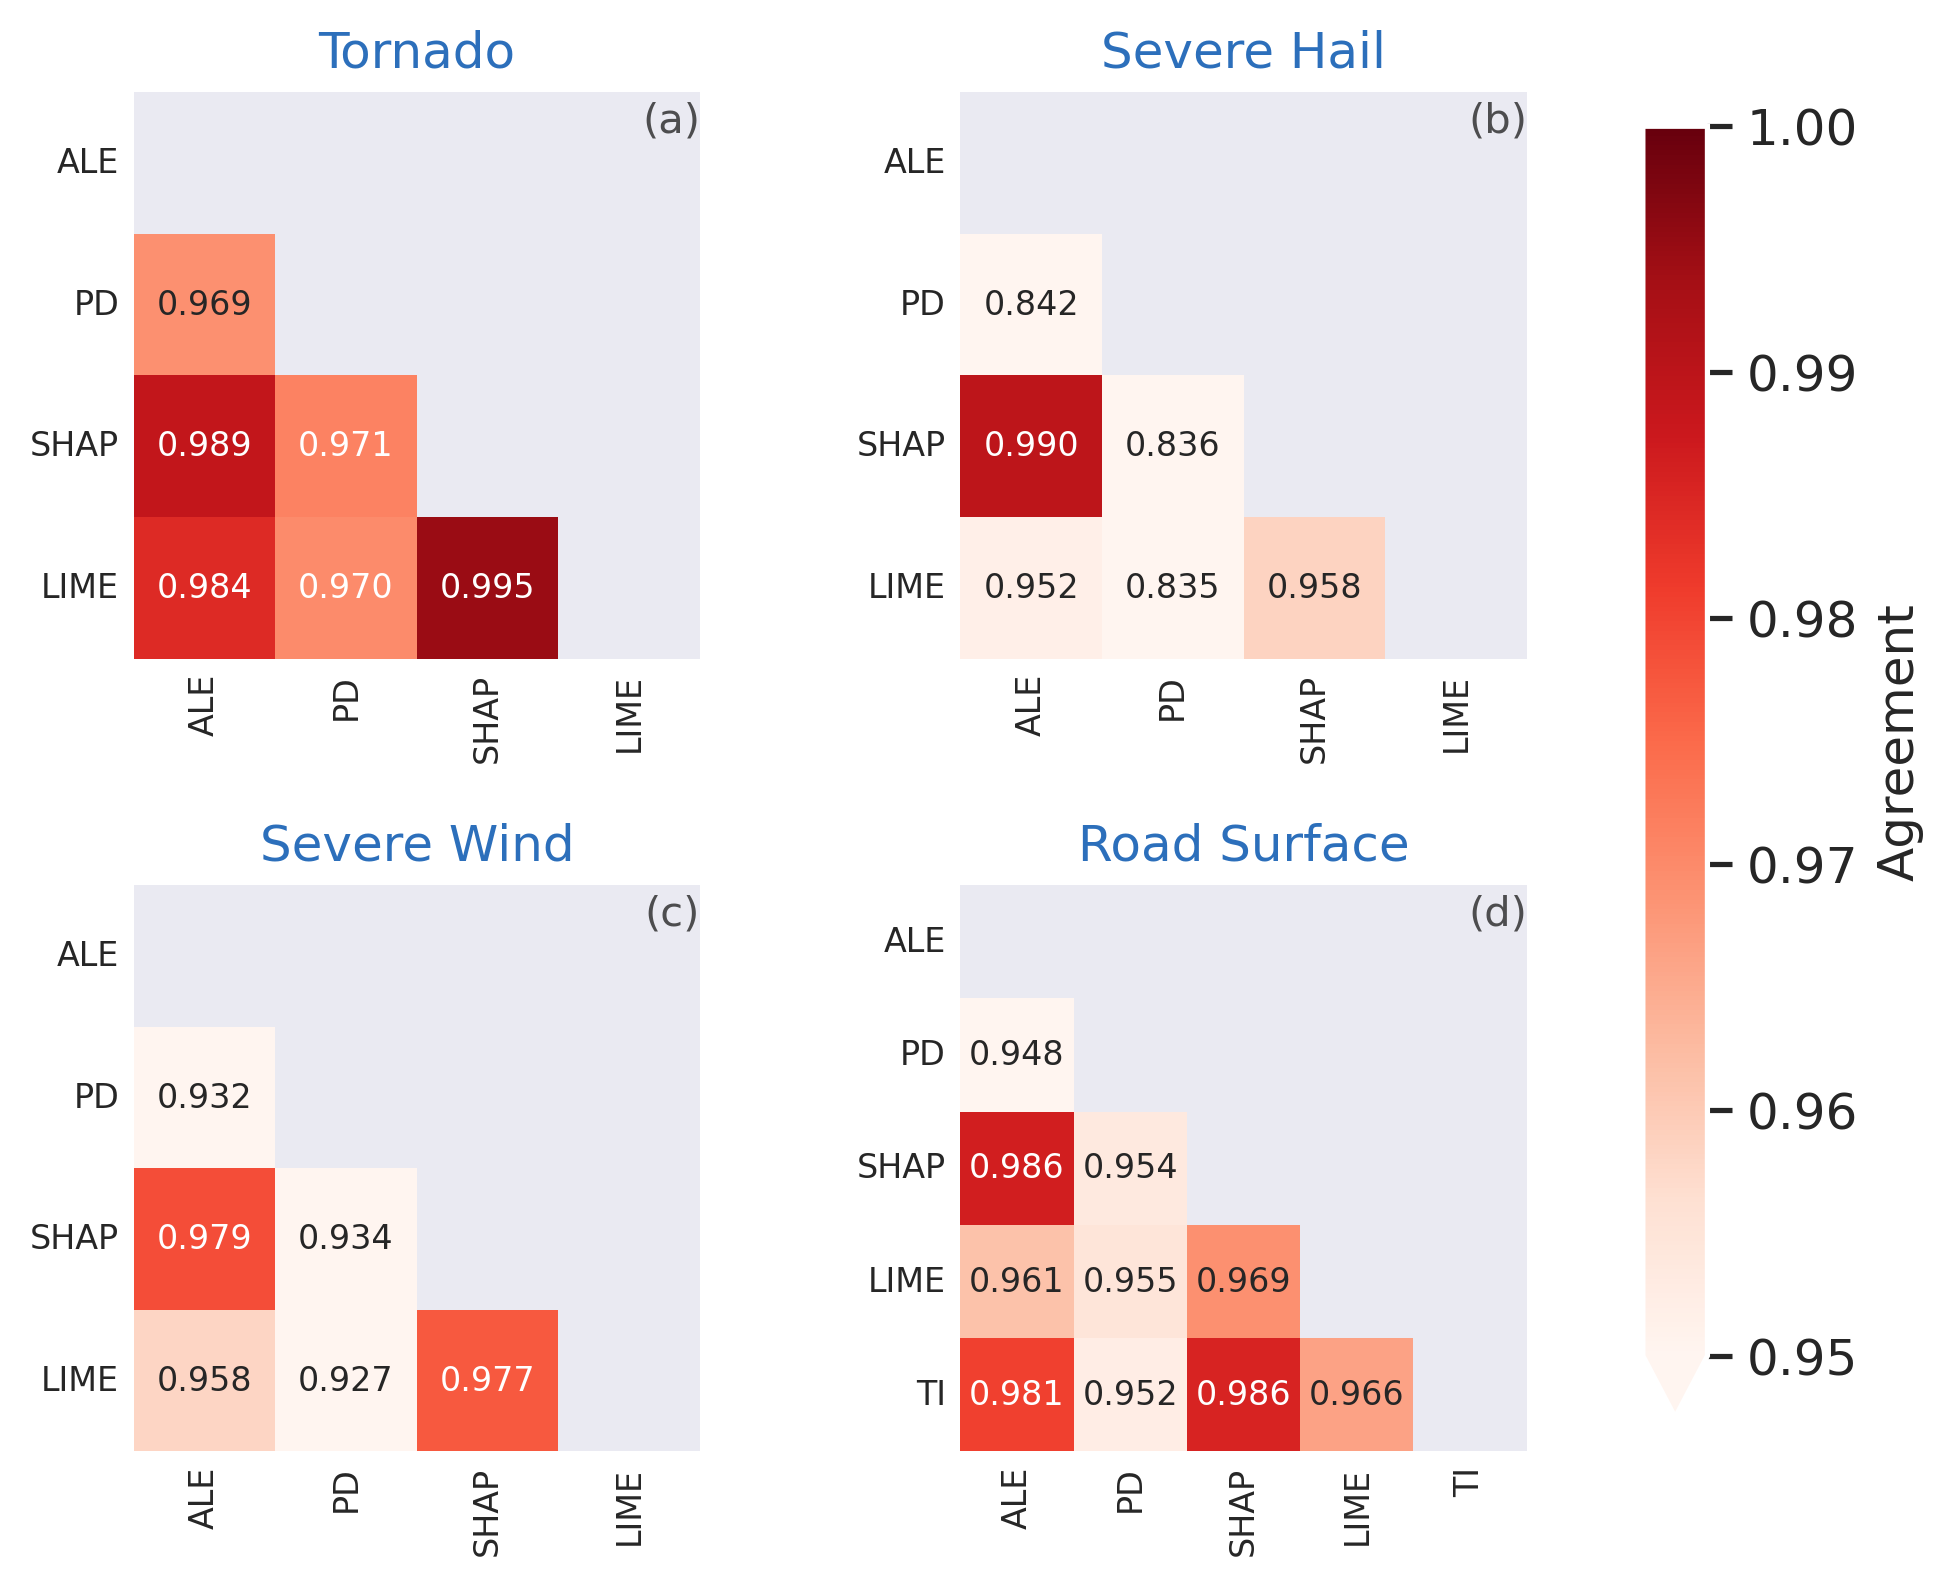

In [10]:
sns.set_theme()
heatmap_multi(data)